In [3]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import sigpy.mri
import sigpy.plot
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

from utils import *

sitk_t1=sitk.ReadImage('../files/t1.nii.gz')
t1=sitk.GetArrayFromImage(sitk_t1)
original = t1[45]
ksp = sigpy.fft(original)

acc_factors = np.array([2, 5, 10])
N_spokes = (256/acc_factors).astype(int)

SNRs = {}
SSIMs = {}

In [2]:
lamdas = [0.001, 0.01, 0.5, 1]
recos = {}

sampled_ksp.shape=(128, 256)


EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]



acc=2 =====================================================


SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

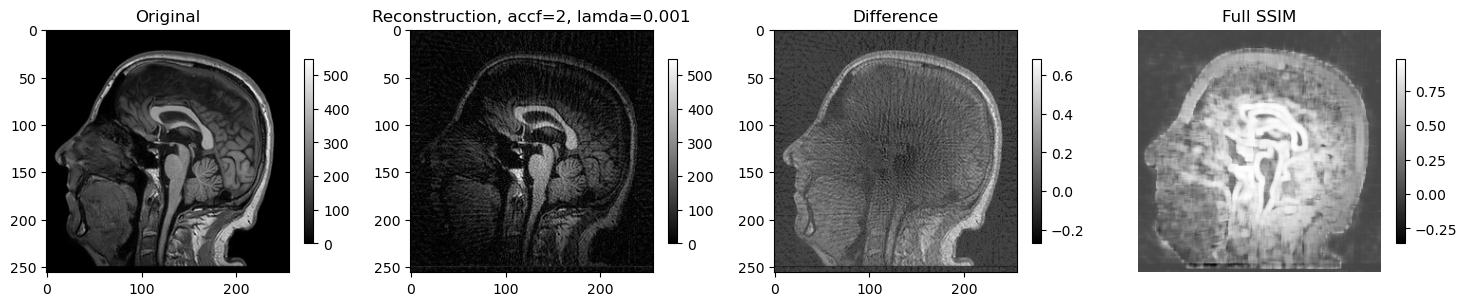

Acceleration factor: 2,    Number of spokes: 128
NUFFT rms reconstruction error: 0.121
PSNR = 53.847908393608684,    MSSIM = 0.38290657891068086


SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

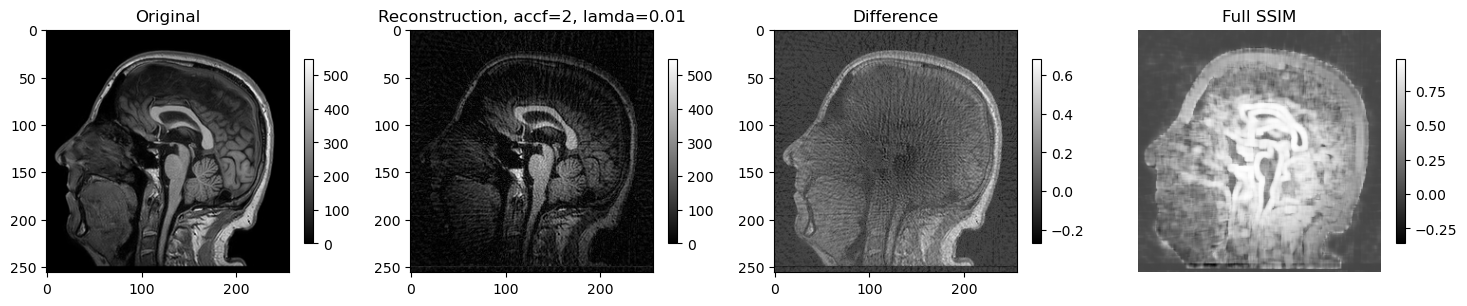

Acceleration factor: 2,    Number of spokes: 128
NUFFT rms reconstruction error: 0.121
PSNR = 53.847908393608684,    MSSIM = 0.38290657891068086


SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

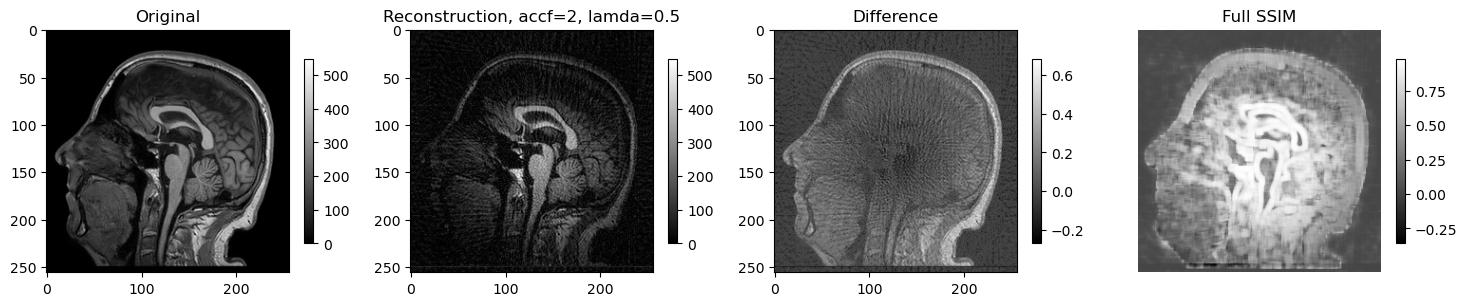

Acceleration factor: 2,    Number of spokes: 128
NUFFT rms reconstruction error: 0.121
PSNR = 53.847908393608684,    MSSIM = 0.38290657891068086


SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

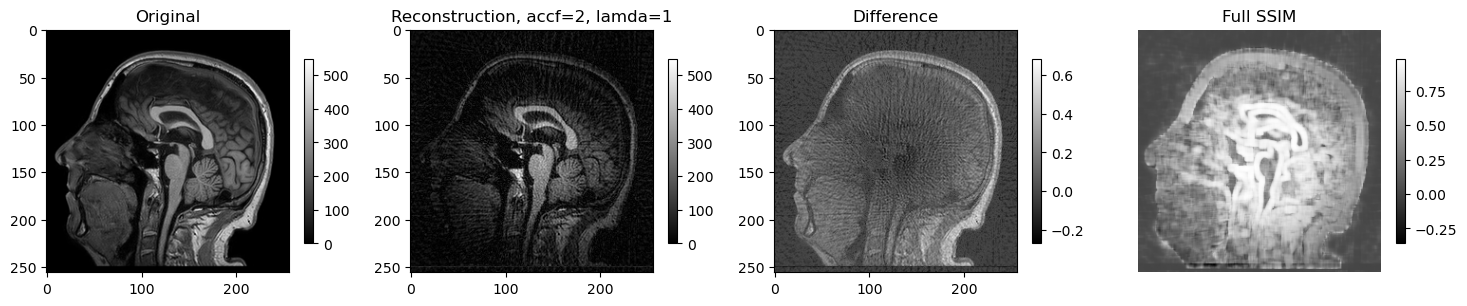

Acceleration factor: 2,    Number of spokes: 128
NUFFT rms reconstruction error: 0.121
PSNR = 53.847908393608684,    MSSIM = 0.38290657891068086


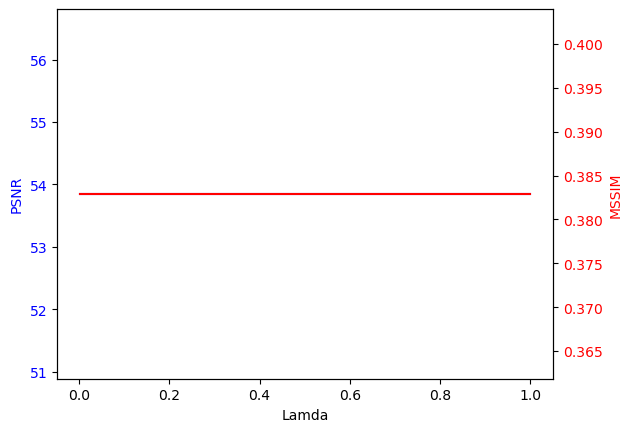

sampled_ksp.shape=(128, 256)


EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]



acc=5 =====================================================


SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

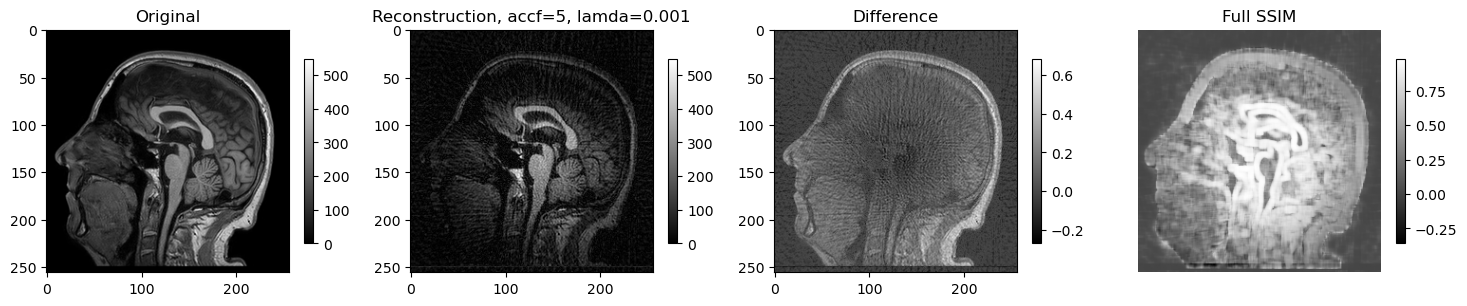

Acceleration factor: 5,    Number of spokes: 51
NUFFT rms reconstruction error: 0.121
PSNR = 53.847908393608684,    MSSIM = 0.38290657891068086


SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

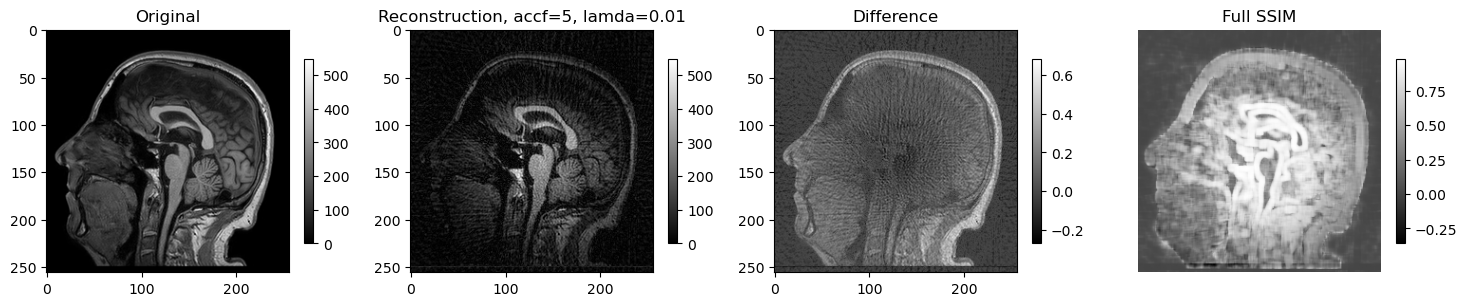

Acceleration factor: 5,    Number of spokes: 51
NUFFT rms reconstruction error: 0.121
PSNR = 53.847908393608684,    MSSIM = 0.38290657891068086


SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

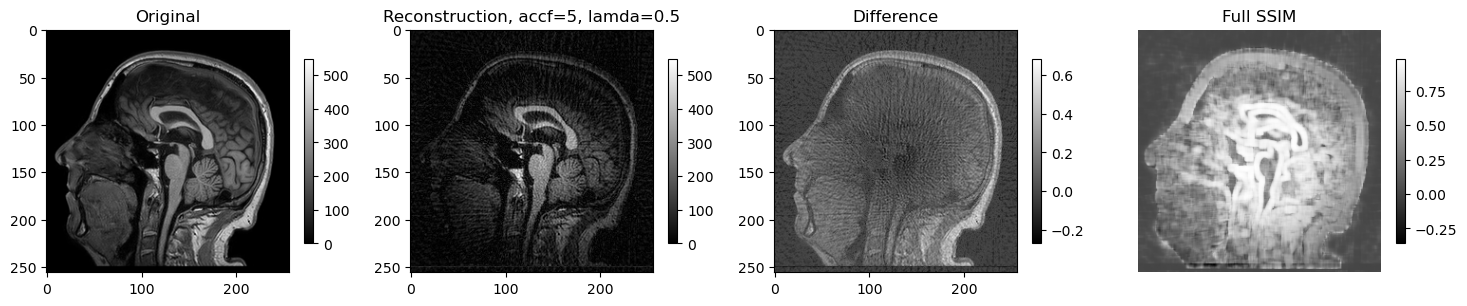

Acceleration factor: 5,    Number of spokes: 51
NUFFT rms reconstruction error: 0.121
PSNR = 53.847908393608684,    MSSIM = 0.38290657891068086


SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

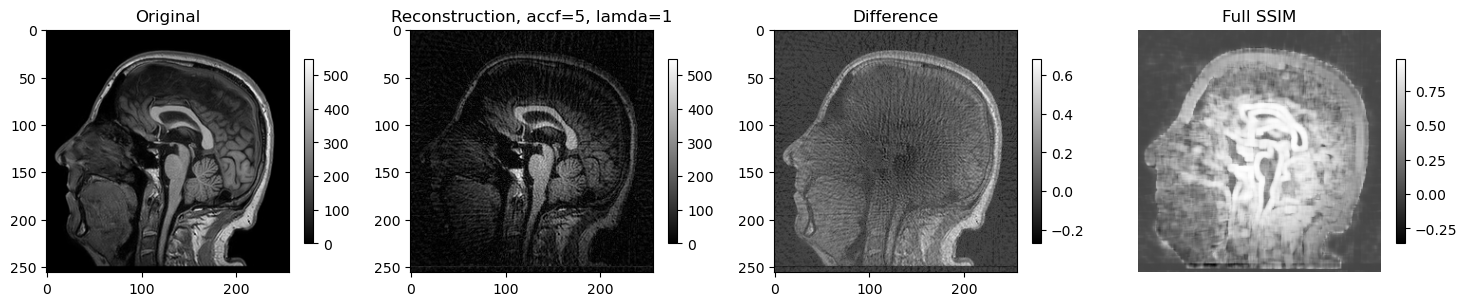

Acceleration factor: 5,    Number of spokes: 51
NUFFT rms reconstruction error: 0.121
PSNR = 53.847908393608684,    MSSIM = 0.38290657891068086


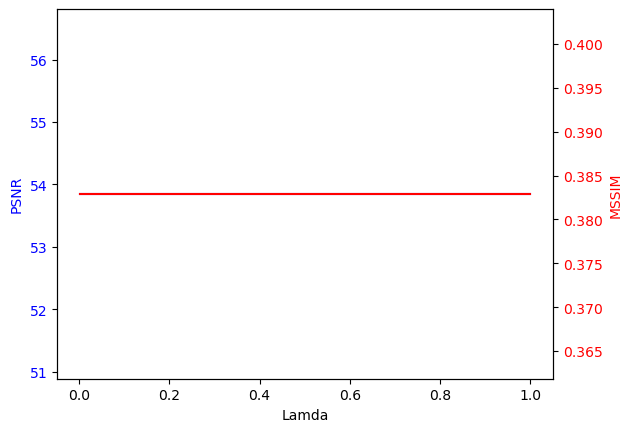

sampled_ksp.shape=(128, 256)


EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]



acc=10 =====================================================


SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

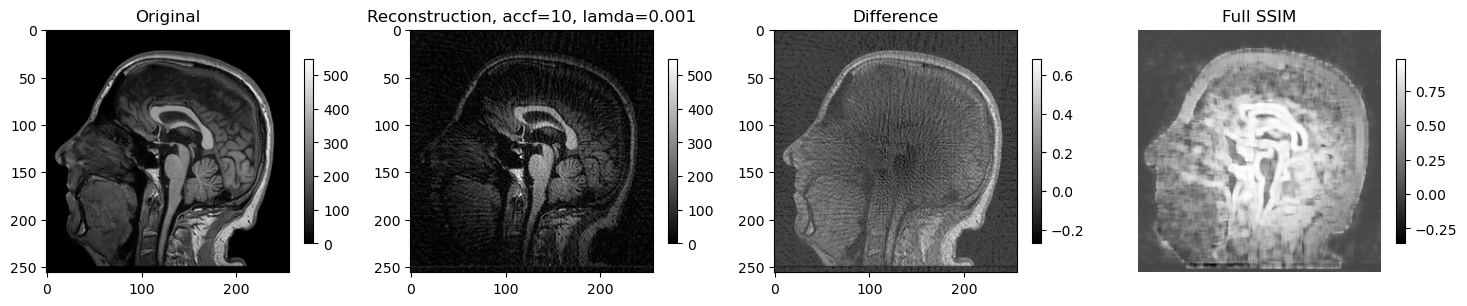

Acceleration factor: 10,    Number of spokes: 25
NUFFT rms reconstruction error: 0.121
PSNR = 53.847908393608684,    MSSIM = 0.38290657891068086


SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

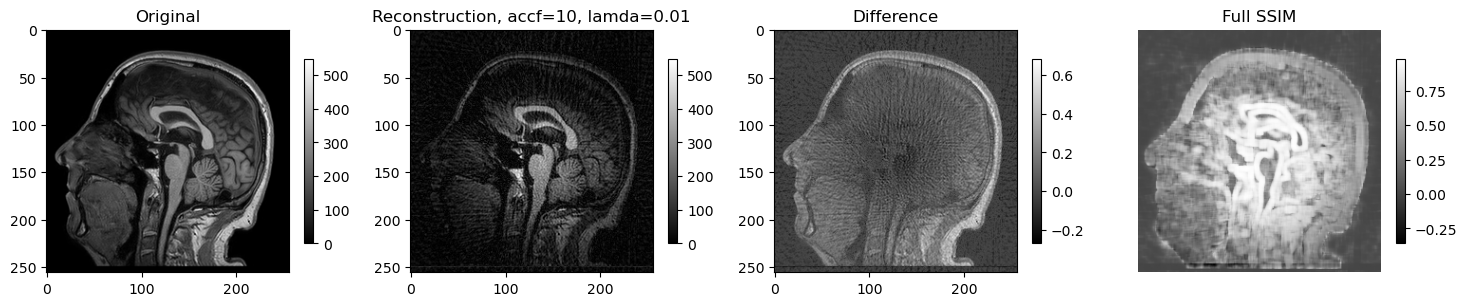

Acceleration factor: 10,    Number of spokes: 25
NUFFT rms reconstruction error: 0.121
PSNR = 53.847908393608684,    MSSIM = 0.38290657891068086


SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

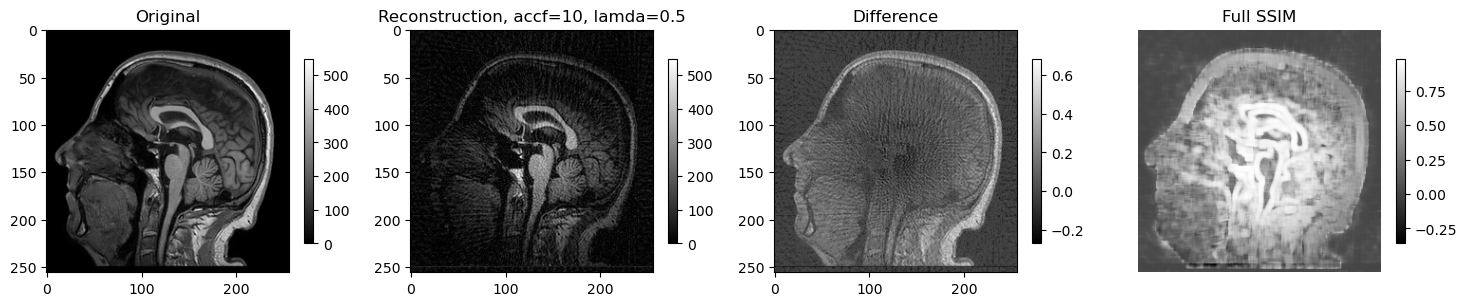

Acceleration factor: 10,    Number of spokes: 25
NUFFT rms reconstruction error: 0.121
PSNR = 53.847908393608684,    MSSIM = 0.38290657891068086


SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

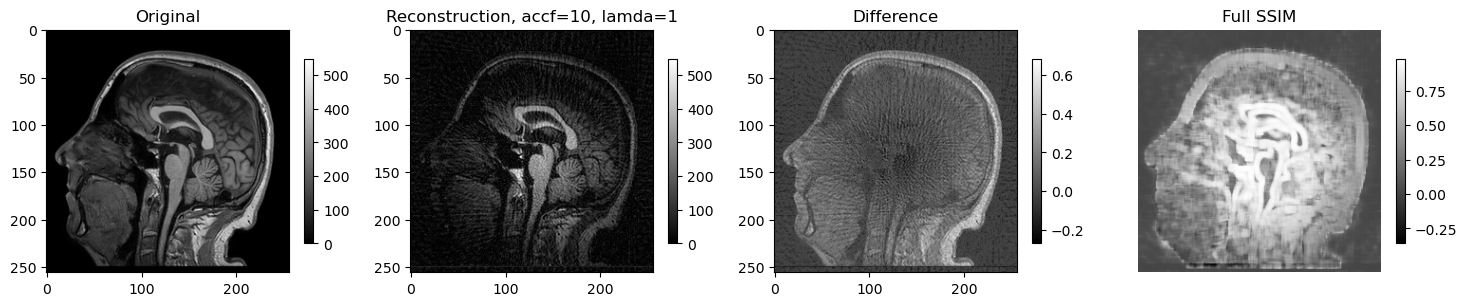

Acceleration factor: 10,    Number of spokes: 25
NUFFT rms reconstruction error: 0.121
PSNR = 53.847908393608684,    MSSIM = 0.38290657891068086


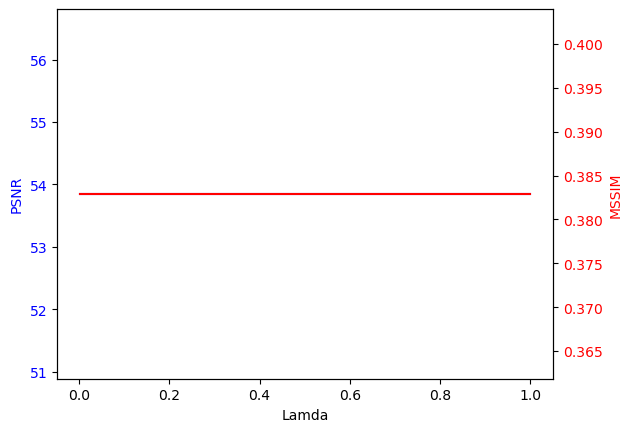

In [4]:
for Nsp, acc in zip(N_spokes, acc_factors):
    sampled_ksp, coord = radial_sampling(ksp, N_spokes[0], n_samples=256, dcomp=True)
    print(f"{sampled_ksp.shape=}")
    gridded_ksp = sigpy.gridding(sampled_ksp, coord, (256,256))
    gridded_ksp = gridded_ksp[np.newaxis,...]
    recos[acc]={}
    SNRs[acc] = {}
    SSIMs[acc] = {}
    #Estimate coil sensitivity
    mps = sigpy.mri.app.EspiritCalib(gridded_ksp).run()
    print("\n")
    print("============================================================")
    print(f"{acc=} =====================================================")
    for l in lamdas:
        reco = sigpy.mri.app.SenseRecon(gridded_ksp, mps, l).run()
        # normalize with respect to maximum value of the original
        reco = scale_by_max(reco, original)
        # Add normalized reconstruction to the recos dict for further analysis
        # The dict contains one dict for each acceleration factor, which, in turn, contain one dict per lamda value, that contains the corresponding reconstruction 
        recos[acc][l] = reco
        # Metrics
        difference = (original - reco)/(original.max()-original.min())
        psnr = peak_signal_noise_ratio(original, reco)
        ssim, S = structural_similarity(original, reco, full=True, data_range=(original.max() - original.min()))
        # Plot
        fig, axs = plt.subplots(1, 4)
        fig.set_figwidth(18)
        plt.axis('off')
        figs = []
        figs.append(axs[0].imshow(original, cmap='gray',))
        figs.append(axs[1].imshow(reco, cmap='gray'))
        figs.append(axs[2].imshow(difference, cmap='gray'))
        figs.append(axs[3].imshow(S, cmap='gray'))
        for f, a in zip(figs,axs):
            fig.colorbar(f, ax=a, shrink=0.5)
        axs[0].set_title('Original')
        axs[1].set_title(f'Reconstruction, accf={acc}, lamda={l}')
        axs[2].set_title('Difference')
        axs[3].set_title('Full SSIM')
        plt.show()
        print(f"Acceleration factor: {acc},    Number of spokes: {Nsp}")
        print(f'NUFFT rms reconstruction error: {np.sqrt(np.mean(difference**2)):.3g}')
        print(f"PSNR = {psnr},    MSSIM = {ssim}")
        print("============================================================")
        SNRs[acc][l] = psnr
        SSIMs[acc][l] = ssim
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Lamda')
    ax1.set_ylabel('PSNR', color='blue')
    ax1.plot(lamdas, list(SNRs[acc].values()), color='blue', label='PSNR')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    ax2.set_ylabel('MSSIM', color='red')
    ax2.plot(lamdas, list(SSIMs[acc].values()), color='red', label='MSSIM')
    ax2.tick_params(axis='y', labelcolor='red')
    # ax2.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
    plt.show()